In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
class ConvolutionalVAE(nn.Module):
    def __init__(self, in_channels=3, channels_bottleneck=8):
        super().__init__()

        self.bottleneck = channels_bottleneck
        self.in_channels = in_channels

        self.encoder_conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, self.bottleneck, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.bottleneck),
            nn.ReLU()
        )

        self.conv_mu = nn.Conv2d(self.bottleneck, self.bottleneck, kernel_size=3, stride=1, padding=1)
        self.conv_logvar = nn.Conv2d(self.bottleneck, self.bottleneck, kernel_size=3, stride=1, padding=1)

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(self.bottleneck, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward_enc(self, x):
        conv_enc = self.encoder_conv(x)
        self.spatial_dims = conv_enc.shape[2:]
        mu = self.conv_mu(conv_enc)
        logvar = self.conv_logvar(conv_enc)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z, mu, logvar

    def forward_dec(self, z):
        x = z.view(z.size(0), self.bottleneck, *self.spatial_dims)
        return self.decoder_conv(x)

    def forward(self, x):
        z, mu, logvar = self.forward_enc(x)
        x_recon = self.forward_dec(z)
        return z, x_recon, mu, logvar


In [4]:
# 2. Loss Function
# ----------------------------

def vae_loss(x_recon, x, mu, logvar, kl_weight=1.0):
    recon_loss = nn.functional.mse_loss(x_recon, x, reduction='mean')
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_weight * kl_div



In [8]:
def get_dataloaders(data_dir, img_size=256, batch_size=64):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
    ])

    train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
    val_set = datasets.ImageFolder(os.path.join(data_dir, 'validation'), transform=transform)
    test_set = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [6]:
# 4. Training Loop
# ----------------------------

def train(model, train_loader, val_loader, epochs=10, kl_weight=0.8, lr=1e-3):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            x = x.to(device)
            _, x_recon, mu, logvar = model(x)
            loss = vae_loss(x_recon, x, mu, logvar, kl_weight)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Train Loss: {avg_train_loss:.4f}")

        # Evaluation
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for x, _ in val_loader:
                x = x.to(device)
                _, x_recon, mu, logvar = model(x)
                loss = vae_loss(x_recon, x, mu, logvar, kl_weight)
                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Validation Loss: {avg_val_loss:.4f}")

    return model



In [10]:
data_dir = "/content/drive/MyDrive/Uc_merced_dataset/data"  # Replace with your path
train_loader, val_loader, test_loader = get_dataloaders(data_dir)

In [11]:
vae = ConvolutionalVAE(in_channels=3)
trained_vae = train(vae, train_loader, val_loader, epochs=20, kl_weight=0.8)


Epoch 1/20: 100%|██████████| 23/23 [09:29<00:00, 24.76s/it]


Train Loss: 0.0759
Validation Loss: 0.0487


Epoch 2/20: 100%|██████████| 23/23 [00:08<00:00,  2.64it/s]


Train Loss: 0.0462
Validation Loss: 0.0458


Epoch 3/20: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s]


Train Loss: 0.0440
Validation Loss: 0.0448


Epoch 4/20: 100%|██████████| 23/23 [00:08<00:00,  2.67it/s]


Train Loss: 0.0433
Validation Loss: 0.0443


Epoch 5/20: 100%|██████████| 23/23 [00:08<00:00,  2.61it/s]


Train Loss: 0.0429
Validation Loss: 0.0440


Epoch 6/20: 100%|██████████| 23/23 [00:08<00:00,  2.58it/s]


Train Loss: 0.0427
Validation Loss: 0.0438


Epoch 7/20: 100%|██████████| 23/23 [00:09<00:00,  2.48it/s]


Train Loss: 0.0425
Validation Loss: 0.0437


Epoch 8/20: 100%|██████████| 23/23 [00:08<00:00,  2.60it/s]


Train Loss: 0.0424
Validation Loss: 0.0436


Epoch 9/20: 100%|██████████| 23/23 [00:08<00:00,  2.57it/s]


Train Loss: 0.0423
Validation Loss: 0.0435


Epoch 10/20: 100%|██████████| 23/23 [00:09<00:00,  2.56it/s]


Train Loss: 0.0422
Validation Loss: 0.0434


Epoch 11/20: 100%|██████████| 23/23 [00:09<00:00,  2.51it/s]


Train Loss: 0.0421
Validation Loss: 0.0434


Epoch 12/20: 100%|██████████| 23/23 [00:08<00:00,  2.65it/s]


Train Loss: 0.0420
Validation Loss: 0.0432


Epoch 13/20: 100%|██████████| 23/23 [00:08<00:00,  2.60it/s]


Train Loss: 0.0419
Validation Loss: 0.0432


Epoch 14/20: 100%|██████████| 23/23 [00:09<00:00,  2.53it/s]


Train Loss: 0.0418
Validation Loss: 0.0430


Epoch 15/20: 100%|██████████| 23/23 [00:09<00:00,  2.55it/s]


Train Loss: 0.0417
Validation Loss: 0.0427


Epoch 16/20: 100%|██████████| 23/23 [00:08<00:00,  2.61it/s]


Train Loss: 0.0415
Validation Loss: 0.0426


Epoch 17/20: 100%|██████████| 23/23 [00:08<00:00,  2.58it/s]


Train Loss: 0.0414
Validation Loss: 0.0424


Epoch 18/20: 100%|██████████| 23/23 [00:08<00:00,  2.57it/s]


Train Loss: 0.0412
Validation Loss: 0.0422


Epoch 19/20: 100%|██████████| 23/23 [00:09<00:00,  2.49it/s]


Train Loss: 0.0411
Validation Loss: 0.0421


Epoch 20/20: 100%|██████████| 23/23 [00:08<00:00,  2.64it/s]


Train Loss: 0.0410
Validation Loss: 0.0420


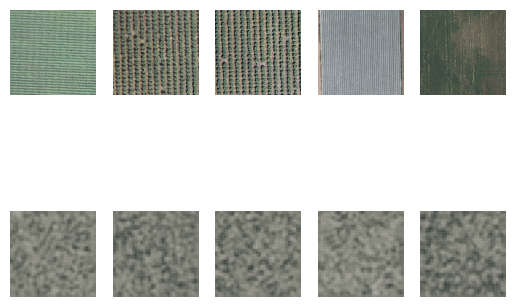

In [12]:
import matplotlib.pyplot as plt

vae.eval()
with torch.no_grad():
    x, _ = next(iter(test_loader))
    x = x.to(device)
    _, x_recon, _, _ = vae(x)

    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(x[i].cpu().permute(1, 2, 0))
        plt.axis('off')

        plt.subplot(2, 5, 5+i+1)
        plt.imshow(x_recon[i].cpu().permute(1, 2, 0))
        plt.axis('off')
    plt.show()
